# Project Setup

## Please install the following libraries

- !pip install vaderSentiment
- !pip install -q transformers
- !pip install praw (If data will be scraped)

## Please do the following imports

In [132]:
# Import Libraries

import csv
import pandas as pd
import os
#import praw (if data will be scraped)
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from scipy.stats import chi2_contingency
from wordcloud import WordCloud


## Set the variables

- scrape_data equal True means to scrape data from Reddit, for which you need to get credential, CLIENT_ID, CLIENT_SECRET, USER_AGENT. If you keep it as False, the code won't scrap, and data will be used from a preloaded CSV file.

- run_sentiment_analysis True means creating the sentiment analysis columns, which takes several minutes (especially for the Hugging Face NLP model). False means to use the sentiment.csv, which already has the columns.

In [49]:
scrape_data = False
run_sentiment_analysis = False

In [ ]:
# Read API credentials from .env file if scrap_data is equal to True
client_id = os.environ['CLIENT_ID']
client_secret = os.environ['CLIENT_SECRET']
user_agent = os.environ['USER_AGENT']

In [24]:
warnings.filterwarnings('ignore')

# Data Collection

For this report, we used posts in Reddit, a social media platform where people can create communities (subreddits) to discuss several topics. For this report, we focused on communities on climate change and collected those posts that are new and hot in the respective subreddit.

The selected subreddits are: 'climatechange', 'climate_science', 'climate', 'environment', 'GlobalClimateChange', 'climate_change', 'ClimateChangeSurprise'

To gather the data set, we used the Reddit API. We created a developer account to get the access credentials to work with this API. Additionally, we used a Python package called Prawn ("Python Reddit API Wrapper"). This wrapper facilitates the interactions with the API.

The final dataset has the following features:

- Title: The post title
- Score: It is a net score that equals upvotes minus downvotes for a particular Reddit post
- Author: Author of the post 
- Time: Data of the post
- Comments: Number of comments done to the post
- UpvoteRatio: It is the ratio between upvotes and total votes
- PostId: Unique identifier for the vote
- Subreddit: Name of the subreddit
- is_nsfw: The content is not safe for work
- SelfText: Is the text in the post
- IsSelfText: This boolean tells if the post has self text (In some cases, there is a link or picture instead)
- IsPinned: Refers to whether a post is pinned to a user's profile page
- IsStickied: Indicates the post is pinned to a subreddit
- IsLocked: This boolean indicates if users are able to make new comments on the post

In [5]:
# Functions used to pull data from reddit

def create_dict_posts(search, kind):
    """ This function transform post into a list of dictionaties form"""
    result = {}
    posts_list = []
    posts = search.new(limit=None) if kind == 'new' else search.top(limit=None)
    for post in posts:
        result["Title"] = post.title
        result["Score"] = post.score
        result["Autor"] = post.author
        result["Time"] = post.created
        result["Comments"] = post.num_comments
        result["UpvoteRatio"] = post.upvote_ratio
        result["PostId"] = post.id
        result["Subreddit"] = post.subreddit.display_name
        result["is_nsfw"] = post.over_18
        result["SelfText"] = post.selftext
        result["IsSelfText"] = post.is_self
        result["IsPinned"] = post.pinned
        result["IsStickied"] = post.stickied
        result["IsPinned"] = post.pinned
        result["IsLocked"] = post.locked
        posts_list.append(result)
        result = {}
    return posts_list


def store_in_CSV(file_name, posts):
    """This function stores data in CSV form"""
    fields = ['Title', 'Score', 'Autor', 'Time', 'Comments', 'UpvoteRatio', 'PostId', 'Subreddit', 'is_nsfw', 'SelfText', 'IsSelfText', 'IsPinned', 'IsStickied', 'IsLocked']
    with open(file_name, 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fields)
        if csvfile.tell() == 0:
            writer.writeheader()
        writer.writerows(posts)

def scrap_dataset(subreddits, file_path, reddit, kind='new'):
    """This functions creates a CSV file based on Reddit data and returns a DataFrame"""
    for sub in subreddits:
        search_results = reddit.subreddit(sub)
        posts = create_dict_posts(search_results, kind)
        store_in_CSV(file_path, posts)
    df = pd.read_csv(file_path)
    print(df.shape)
    return df

In [6]:
# Create a Reddit API client

if scrape_data:
    reddit = praw.Reddit(
        client_id=client_id,
        client_secret=client_secret,
        user_agent=user_agent
    )

In [7]:
# defining the subreddits list
if scrape_data:
    subreddits = ['climatechange', 'climate_science', 'climate', 'environment', 'GlobalClimateChange', 'climate_change', 'ClimateChangeSurprise']
    df = scrap_dataset(subreddits, 'climate_change.csv', reddit, kind='top')
    df.head()

# Data cleaning and Text Preprocessing 

## Numerical Data

In [102]:
data = pd.read_csv('climate_change.csv')

In [103]:
numerical_df = data.select_dtypes(include=['int', 'float'])
numerical_df

,Score,Time,Comments,UpvoteRatio
0,718,1.550104e+09,534,0.98
1,30,1.661115e+09,14,0.91
2,75,1.697987e+09,296,0.75
3,21,1.698006e+09,26,0.70
4,9,1.698013e+09,30,0.74
...,...,...,...,...
15970,3,1.600180e+09,0,0.80
15971,3,1.579589e+09,0,0.72
15972,2,1.686929e+09,0,0.63
15973,1,1.659286e+09,0,0.56


# Model Building

## Sentiment Analysis

We want to understand the sentiment behind the posts; we expect them to be primarily negative. Additionally, we want to identify for each group (positive, negative, and neutral) what are the most common words. Furthermore, we want to compare the scores for these groups to determine if their sentiment drives the post score somehow.

In [59]:
if run_sentiment_analysis:
    # Instantiate Vader analyser
    analyzer = SentimentIntensityAnalyzer()
    # Instantiate Hugging Face classifier
    sentiment_classifier = pipeline(
        model="lxyuan/distilbert-base-multilingual-cased-sentiments-student"
    )

def get_sentiment_vader(sentence):
    score = analyser.polarity_scores(sentence)
    if score['pos'] > 0.6:
        return 'pos'
    elif score['neg'] > 0.6:
        return 'neg'
    else:
        return 'neu'

def get_sentiment_HF(sentence):
    score = sentiment_classifier(sentence)
    return score[0]['label']

In [104]:
if run_sentiment_analysis:
    data = pd.read_csv('climate_change.csv')
    # creating a new column called Sentiment
    data['Sentiment_v'] = data['Title'].apply(get_sentiment_vader)
    # creating a new column called Sentiment hf (Hugging Face)
    data['Sentiment_hf'] = data['Title'].apply(get_sentiment_HF)
else:
    data = pd.read_csv('sentiment.csv')
    

In [105]:
# Groups with vader sentiment

data['Sentiment_v'].value_counts()


neu    15938
neg       26
pos       11
Name: Sentiment_v, dtype: int64

In [106]:
sentiment_counts = data['Sentiment_hf'].value_counts()
sentiment_counts

negative    9293
positive    6455
neutral      227
Name: Sentiment_hf, dtype: int64

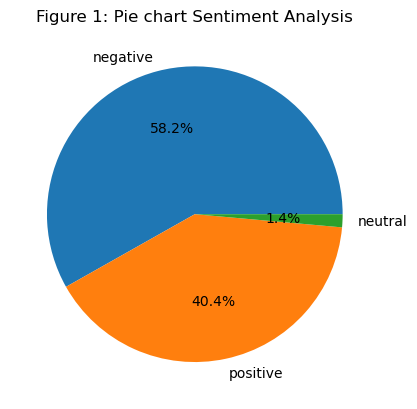

In [107]:
# pie chart for Sentiment Analysis Hugging Face

plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%')
plt.title("Figure 1: Pie chart Sentiment Analysis")
plt.show()


Note:

- We just used the 'Title' column for sentiment analysis as we hypothesized that the Title should have enough information about the post intention.

- Additionally, we decided not to apply textual data cleaning as we don't want to remove essential signs of intention that may be included in punctuation, stop words, or upper cases.
'
- In conclusion, Vader was not a successful alternative for this dataset, as the 'Title' rows were primarily classified as neutral. Therefore, we explored an NLP model from Hugging Face (distilbert-base-multilingual-cased-sentiments-student) to do the sentiment analysis. This last model was able to perceive better the intention in the content. We added the model response to a new column called 'Sentiment_hf'.

- As we had Hypothesized, the majority of the posts are negative, with a 58.2%, followed by the positive posts, with a 40.4%

### Sentiment vs Score

In [108]:
data.head()

,Title,Score,Autor,Time,Comments,UpvoteRatio,PostId,Subreddit,is_nsfw,SelfText,IsSelfText,IsPinned,IsStickied,IsLocked,Sentiment_v,Sentiment_hf
0,I'm afraid climate change is going to kill me!...,718,Will_Power,1.550104e+09,534,0.98,aqdmbz,climatechange,False,Feeling scared? Have you been listening to or ...,True,False,True,False,neu,negative
1,The r/climatechange Verified User Flair Program,30,technologyisnatural,1.661115e+09,14,0.91,wu9zny,climatechange,False,r/climatechange is a community centered around...,True,False,True,False,neu,positive
2,How come some environmentalists are against ca...,75,SnooMarzipans7682,1.697987e+09,296,0.75,17dv720,climatechange,False,It seems like if we could capture all of the c...,True,False,False,False,neu,negative
3,Solar and wind are better than nuclear,21,Consistent_Piano_210,1.698006e+09,26,0.70,17e251o,climatechange,False,Taken from a discussion:\n\nNickel Iron batter...,True,False,False,False,neu,positive
4,When will we hit 2 degrees of global warming?,9,ging289,1.698013e+09,30,0.74,17e506w,climatechange,False,Now we can't avoid hitting 1.5 degrees so I as...,True,False,False,False,neu,negative


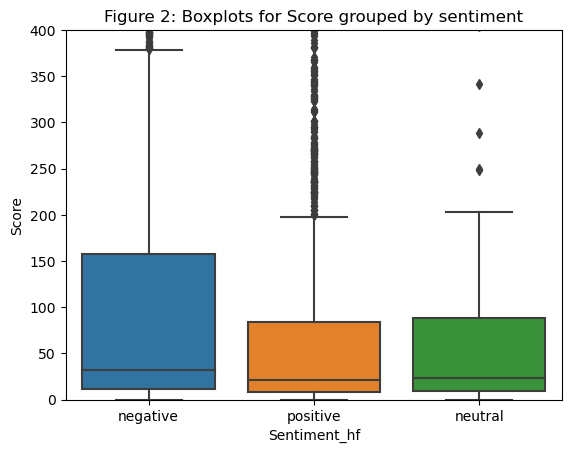

In [111]:
# Checking differences in score between to sentiments
ax = sns.boxplot(x='Sentiment_hf', y='Score', data=data)
ax.set_ylim(0, 400)
ax.set_title('Figure 2: Boxplots for Score grouped by sentiment')
plt.show()

Note:

- When we look at the differences in 'Score' grouping by sentiment, we can conclude that positive and neutral comments have similar distributions. In contrast, negative titles present a different distribution, with higher values in median and maximum, which may indicate that negative titles drive higher scores than positive or neutral titles.

- We conducted a chi-square analysis to confirm that the negative vs non-negative are different.

In [124]:
data_neg_pos = data[(data['Sentiment_hf'] == 'negative') | (data['Sentiment_hf'] == 'positive')]

In [125]:
def get_pvalue(data, cat, num):
    # Contingency table
    contingency_table = pd.crosstab(data[cat], data[num])
    # Chi-square test
    _, p, _, _ = chi2_contingency(contingency_table)

    return p


In [126]:
# Comparing positive vs negative
get_pvalue(data_neg_pos, 'Sentiment_hf', 'Score')

0.22759768729069613

In [127]:
data_neu_pos = data[(data['Sentiment_hf'] == 'neutral') | (data['Sentiment_hf'] == 'positive')]

In [131]:
# Comparing positive vs neutral
get_pvalue(data_neu_pos, 'Sentiment_hf', 'Score')

0.00041736201403184183

Notes:
    
- We confirmed by using the chi-square test that there is a significant association between the positive and neutral (p < 0.05) groups. In contrast, there is no significant association between negatives and positives (p > 0.05). Therefore, we can conclude that negative posts drive a higher score than positive or neutral comments.


### Word Cloud Analysis

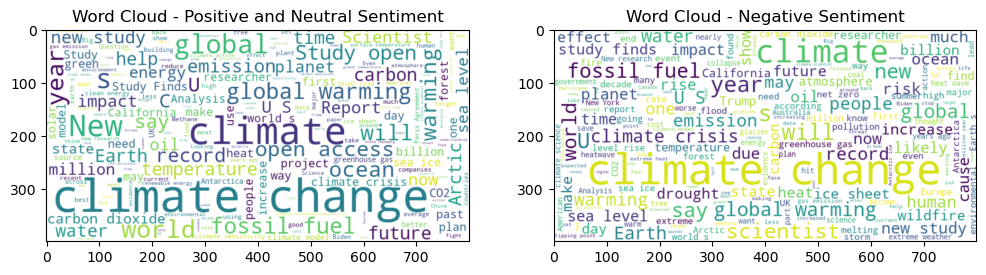

In [134]:
# dividing between negative and non-negative text
positive_txt = ' '.join(data_neu_pos['Title'])
negative_txt = ' '.join(data[data['Sentiment_hf'] == 'negative']['Title'])

wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_txt)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_txt)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud - Positive and Neutral Sentiment')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud - Negative Sentiment')

plt.show()

# References

- https://huggingface.co/lxyuan/distilbert-base-multilingual-cased-sentiments-student